<a href="https://colab.research.google.com/github/shreya0202/NLP/blob/master/NLP_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p><img alt="Colaboratory logo" height="45px" src="/img/colab_favicon.ico" align="left" hspace="10px" vspace="0px"></p>

<h1>Welcome to Colaboratory!</h1>


Colaboratory is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud.

With Colaboratory you can write and execute code, save and share your analyses, and access powerful computing resources, all for free from your browser.

In [0]:
#import pandas library for reading the dataset
import pandas as pd

#import sklearn model selection package to split data into train and test models
from sklearn.model_selection import train_test_split

#import numpy library for data manipulation
import numpy as np 

In [18]:
#code for connecting google drive to access the dataset that is stored there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
#reading CSV file and storing in a variable
dataset = pd.read_csv('/content/drive/My Drive/housing.csv')

#removing null values
dataset = dataset.dropna()

print("Here are the first five roes of the dataset: ")
#printing first 10 records of dataset
dataset.head(10)

Here are the first five roes of the dataset: 


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


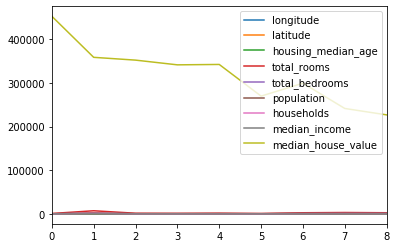

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(dataset)
df.columns
plt.figure
#df.iloc[0:9].plot()
#df.plot(subplots=True, layout=(1,10), ylim=[0,10])
#dataset.plot()

df[0:9].plot()

In [0]:
#output Y is the median housing value to be predicted
Y = dataset['median_house_value']

#input x contains remaining columns from longitude to median income
X = dataset.loc[:,'longitude':'median_income']

In [0]:
#splitting dataset into 70% training and 30% testing  
#setting random state to 2003 for generating same random sequence each time
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 2003)

#converting train and test data to  numpy arrays
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_test_np = x_test.to_numpy()
y_test = y_test.to_numpy()


In [0]:
#importing PyTorch library
import torch

#importing 1D convolution layer
from torch.nn import Conv1d

#importing max pool layer
from torch.nn import MaxPool1d

#importing flatten layer
from torch.nn import Flatten

#importing linear layer
from torch.nn import Linear

#importing relu function
from torch.nn.functional import relu

#importing dataloaded and tensordataset from pytorch
from torch.utils.data import DataLoader, TensorDataset

In [0]:
class CnnRegressor(torch.nn.Module):
  #defining initialization method
  def __init__(self, batch_size, inputs, outputs):
    #initializing super class and storing parameters
    super(CnnRegressor, self).__init__()
    self.batch_size = batch_size
    self.inputs = inputs
    self.outputs = outputs
    #defining input layer with kernel size 3
    self.input_layer = Conv1d(inputs, batch_size,1)
    #defining max pooling layer with kernel size 3
    self.max_pooling_layer = MaxPool1d(1)
    #defining convolution layer with kernel size 3
    self.conv_layer = Conv1d(batch_size, 128, 1)
    #defining flatter layer
    self.flattern_layer = Flatten()
    #defining linear layer
    self.linear_layer = Linear(128, 64)
    #defining output layer
    self.output_layer = Linear(64, outputs)

#method to feed inputs to the model
  def feed(self, input):
    #reshaping the input to be feed to the input layer
    input = input.reshape((self.batch_size, self.inputs, 1))
    #passing the input through relu function and getting output for first layer
    output = relu(self.input_layer(input))
    #passing output of the first layer as input in max pooling layer
    output = self.max_pooling_layer(output)
    #passing output of the second layer as input in relu function
    output = relu(self.conv_layer(output))
    #getting output for flatten layer
    output = self.flattern_layer(output)
    #getting output for linear layer
    output = self.linear_layer(output)
    #getting final output
    output = self.output_layer(output)
    return output



In [39]:
#import Stochastic gradient descent package from PyTorch
from torch.optim import SGD

#import mean absolute error loss package from PyTorch
from torch.nn import L1Loss

#import r^2 score package from pytorch's ignite
!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [78]:
#setting up batch size
batch_size = 64
#calling the CNN regressor function to build the model
model = CnnRegressor(batch_size, X.shape[1], 1)
#passing off the model to GPU for processing
model.cuda()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flattern_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
#method to return MSE and R^2 scores
def model_loss(model, dataset, train = False, optimizer = None):
  performance = L1Loss()
  score_metric = R2Score()
  avg_loss = 0
  avg_score = 0
  count = 0
  for input, output in iter(dataset):
    #getting prediction for training dataset
    predictions = model.feed(input)
    #getting the MSE loss
    loss = performance(predictions, output)
    #getting R^2 score
    score_metric.update([predictions, output])
    score = score_metric.compute()

    if(train):
      #clear errors
      optimizer.zero_grad()
      #compute gradients
      loss.backward()
      #update parameters based on gradients
      optimizer.step()
    
    #storing the loss and updating counter
    avg_loss += loss.item()
    avg_score += score
    count += 1
 #returning MSE and R^2 scores per count
  return avg_loss / count, avg_score / count

In [80]:
epochs = 10
optimizer = SGD(model.parameters(), lr=1e-5)
inputs = torch.from_numpy(x_train_np).cuda().float()
outputs = torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()

tensor = TensorDataset(inputs, outputs)
loader = DataLoader(tensor, batch_size, shuffle=True, drop_last=True)

for epoch in range(epochs):
  avg_loss, avg_r2_score = model_loss(model, loader, train=True, optimizer=optimizer)

  print("Epoch : " + str(epoch + 1) + ":\n\tLoss = " + str(avg_loss) + "\n\tR^2 Score = " + str(avg_r2_score))


Epoch : 1:
	Loss = 138722.05048346412
	R^2 Score = -2.2682592513871533
Epoch : 2:
	Loss = 117082.88225196188
	R^2 Score = -1.0741728478363748
Epoch : 3:
	Loss = 115275.87591087444
	R^2 Score = -1.0272656474671917
Epoch : 4:
	Loss = 111167.12387892377
	R^2 Score = -0.7699610614792418
Epoch : 5:
	Loss = 110399.92821608744
	R^2 Score = -0.8107905496344203
Epoch : 6:
	Loss = 107486.58916059417
	R^2 Score = -0.673028576827464
Epoch : 7:
	Loss = 104506.82087303812
	R^2 Score = -0.7009303081137338
Epoch : 8:
	Loss = 103075.18021300448
	R^2 Score = -0.5690634589991117
Epoch : 9:
	Loss = 100052.5456838565
	R^2 Score = -0.4204172195595252
Epoch : 10:
	Loss = 97889.78615470852
	R^2 Score = -0.32725088863365676


In [0]:
#@title Introducing Colaboratory { display-mode: "form" }
#@markdown This 3-minute video gives an overview of the key features of Colaboratory:
from IPython.display import YouTubeVideo
YouTubeVideo('inN8seMm7UI', width=600, height=400)

## Getting Started

The document you are reading is a  [Jupyter notebook](https://jupyter.org/), hosted in Colaboratory. It is not a static page, but an interactive environment that lets you write and execute code in Python and other languages.

For example, here is a **code cell** with a short Python script that computes a value, stores it in a variable, and prints the result:

In [0]:
seconds_in_a_day = 24 * 60 * 60
seconds_in_a_day

86400

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


To execute the code in the above cell, select it with a click and then either press the play button to the left of the code, or use the keyboard shortcut "Command/Ctrl+Enter".

All cells modify the same global state, so variables that you define by executing a cell can be used in other cells:

In [0]:
seconds_in_a_week = 7 * seconds_in_a_day
seconds_in_a_week

604800

For more information about working with Colaboratory notebooks, see [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb).


## More Resources

Learn how to make the most of Python, Jupyter, Colaboratory, and related tools with these resources:

### Working with Notebooks in Colaboratory
- [Overview of Colaboratory](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)
- <img src="/img/new.png" height="20px" align="left" hspace="4px" alt="New"></img>
 [TensorFlow 2 in Colab](/notebooks/tensorflow_version.ipynb)

### Working with Data
- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb) 
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

### Machine Learning Crash Course
These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas](/notebooks/mlcc/intro_to_pandas.ipynb)
- [Tensorflow concepts](/notebooks/mlcc/tensorflow_programming_concepts.ipynb)
- [First steps with TensorFlow](/notebooks/mlcc/first_steps_with_tensor_flow.ipynb)
- [Intro to neural nets](/notebooks/mlcc/intro_to_neural_nets.ipynb)
- [Intro to sparse data and embeddings](/notebooks/mlcc/intro_to_sparse_data_and_embeddings.ipynb)

### Using Accelerated Hardware
- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

## Machine Learning Examples: Seedbank

To see end-to-end examples of the interactive machine learning analyses that Colaboratory makes possible, check out the [Seedbank](https://research.google.com/seedbank/) project.

A few featured examples:

- [Neural Style Transfer](https://research.google.com/seedbank/seed/neural_style_transfer_with_tfkeras): Use deep learning to transfer style between images.
- [EZ NSynth](https://research.google.com/seedbank/seed/ez_nsynth): Synthesize audio with WaveNet auto-encoders.
- [Fashion MNIST with Keras and TPUs](https://research.google.com/seedbank/seed/fashion_mnist_with_keras_and_tpus): Classify fashion-related images with deep learning.
- [DeepDream](https://research.google.com/seedbank/seed/deepdream): Produce DeepDream images from your own photos.
- [Convolutional VAE](https://research.google.com/seedbank/seed/convolutional_vae): Create a generative model of handwritten digits.